# Azure AI Content Understanding
## Extract Custom Fields
<img src="https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/component-overview.png">

https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview

In [1]:
import datetime
import json
import os
import sys

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure_content_understanding import AzureContentUnderstandingClient
from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Video, Audio, FileLink, Markdown
from PIL import Image

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

## Settings

In [3]:
load_dotenv("azure.env")

AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")

In [4]:
AZURE_AI_API_VERSION = "2024-12-01-preview"

In [5]:
credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(
    credential, "https://cognitiveservices.azure.com/.default")

client = AzureContentUnderstandingClient(
    endpoint=AZURE_AI_ENDPOINT,
    api_version=AZURE_AI_API_VERSION,
    token_provider=token_provider,
    x_ms_useragent=
    "azure-ai-content-understanding-python/content_extraction",  # This header is used for sample usage telemetry
)

In [6]:
DOCS_DIR = "documents"
JSON_DIR = "json"

## Invoice example

In [7]:
ANALYZER_SAMPLE_FILE = os.path.join(DOCS_DIR, 'invoice.pdf')

ANALYZER_TEMPLATE_FILE = os.path.join(JSON_DIR, 'invoice.json')
ANALYZER_ID = f"content-doc-sample-{(datetime.datetime.today().strftime('%d%b%Y%H%M%S'))}"

In [8]:
LINK = FileLink(path=ANALYZER_SAMPLE_FILE)
print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/Azure Content Understanding/documents/invoice.pdf

In [9]:
with open(ANALYZER_TEMPLATE_FILE, 'r') as f:
    print(f.read())

{
  "description": "Sample invoice analyzer",
  "scenario": "document",
  "fieldSchema": {
    "fields": {
      "VendorName": {
        "type": "string",
        "method": "extract",
        "description": "Vendor issuing the invoice"
      },
      "Items": {
        "type": "array",
        "method": "extract",
        "items": {
          "type": "object",
          "properties": {
            "Description": {
              "type": "string",
              "method": "extract",
              "description": "Description of the item"
            },
            "Amount": {
              "type": "number",
              "method": "extract",
              "description": "Amount of the item"
            }
          }
        }
      }
    }
  }
}


In [10]:
# Create analyzer
response = client.begin_create_analyzer(
    ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_FILE)
result = client.poll_result(response)

# Analyzer file
response = client.begin_analyze(ANALYZER_ID,
                                file_location=ANALYZER_SAMPLE_FILE)
result = client.poll_result(response)

In [11]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "eb7058c9-bab9-4758-afb3-5607f088b363",
    "status": "Succeeded",
    "result": {
        "analyzerId": "content-doc-sample-28Jan2025145639",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-01-28T14:56:43Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "CONTOSO LTD.\n\n\n# INVOICE\n\nContoso Headquarters\n123 456th St\nNew York, NY, 10001\n\nINVOICE: INV-100\n\nINVOICE DATE: 11/15/2019\n\nDUE DATE: 12/15/2019\n\nCUSTOMER NAME: MICROSOFT CORPORATION\n\nSERVICE PERIOD: 10/14/2019 - 11/14/2019\n\nCUSTOMER ID: CID-12345\n\nMicrosoft Corp\n123 Other St,\nRedmond WA, 98052\n\nBILL TO:\n\nMicrosoft Finance\n\n123 Bill St,\n\nRedmond WA, 98052\n\nSHIP TO:\n\nMicrosoft Delivery\n\n123 Ship St,\n\nRedmond WA, 98052\n\nSERVICE ADDRESS:\nMicrosoft Services\n123 Service St,\nRedmond WA, 98052\n\n\n<table>\n<tr>\n<th>SALESPERSON</th>\n<th>P.O. NUMBER</th>\n<th>REQUISITIONER</th>\n<th>SHIPPED VIA</th>\n<th>F.O.B. POINT</t

In [12]:
print("\033[1;31;34m")
print(json.dumps(result["result"]["contents"][0]["fields"], indent=4))


{
    "VendorName": {
        "type": "string",
        "valueString": "CONTOSO LTD.",
        "spans": [
            {
                "offset": 0,
                "length": 12
            }
        ],
        "confidence": 0.941,
        "source": "D(1,0.5729,0.6582,2.3353,0.6582,2.3353,0.8957,0.5729,0.8957)"
    },
    "Items": {
        "type": "array",
        "valueArray": [
            {
                "type": "object",
                "valueObject": {
                    "Description": {
                        "type": "string",
                        "valueString": "Consulting Services",
                        "spans": [
                            {
                                "offset": 909,
                                "length": 19
                            }
                        ],
                        "confidence": 0.971,
                        "source": "D(1,2.3264,5.673,3.6413,5.673,3.6413,5.8402,2.3264,5.8402)"
                    },
                

In [13]:
client.delete_analyzer(ANALYZER_ID)

<Response [204]>

## Receipt example

In [14]:
ANALYZER_SAMPLE_FILE = os.path.join(DOCS_DIR, 'receipt.jpg')

ANALYZER_TEMPLATE_FILE = os.path.join(JSON_DIR, 'receipt.json')
ANALYZER_ID = f"content-doc-sample-{(datetime.datetime.today().strftime('%d%b%Y%H%M%S'))}"

In [15]:
LINK = FileLink(path=ANALYZER_SAMPLE_FILE)
print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/Azure Content Understanding/documents/receipt.jpg

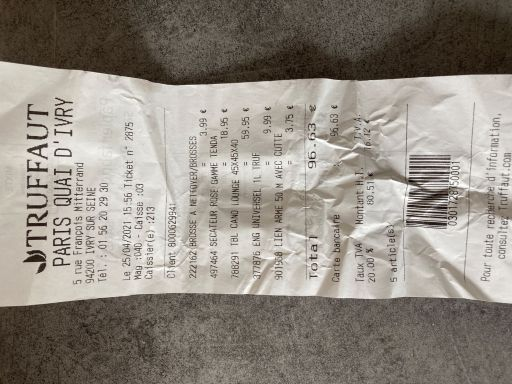

In [16]:
img = Image.open(ANALYZER_SAMPLE_FILE)
img

In [17]:
with open(ANALYZER_TEMPLATE_FILE, 'r') as f:
    print(f.read())

{
    "description": "Extract useful information from receipt",
    "scenario": "document",
    "fieldSchema": {
        "fields": {
            "MerchantName": {
                "type": "string",
                "method": "extract",
                "description": ""
            },
            "Items": {
                "type": "array",
                "method": "generate",
                "description": "",
                "items": {
                    "type": "object",
                    "method": "extract",
                    "properties": {
                        "Quantity": {
                            "type": "string",
                            "method": "extract",
                            "description": ""
                        },
                        "Name": {
                            "type": "string",
                            "method": "extract",
                            "description": ""
                        },
                        "Price": {
   

In [18]:
# Create analyzer
response = client.begin_create_analyzer(
    ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_FILE)
result = client.poll_result(response)

# Analyzer file
response = client.begin_analyze(ANALYZER_ID,
                                file_location=ANALYZER_SAMPLE_FILE)
result = client.poll_result(response)

In [19]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "2c0d8b07-c222-4b54-bacb-105a7d39ee18",
    "status": "Succeeded",
    "result": {
        "analyzerId": "content-doc-sample-28Jan2025145656",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-01-28T14:57:00Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "<figure>\n\nTRUFFAUT\nPARIS QUAI D'IVRY\n\n</figure>\n\n\n5 rue Fran\u00e7ois Mitterrand\n94200 IVRY SUR SEINE\nT\u00e9l. : 01 56 20 29 30\n\nLe 25/04/2021 15:56 Ticket n\u00ba 2875\n\nMag :D40 - Caisse :03\n\nCaissier(e) :213\n\nClient 8000629941\n\n\n<table>\n<tr>\n<th></th>\n<th>222162</th>\n<th>BROSSE</th>\n<th>A</th>\n<th colspan=\"3\">NETTOYER/BROSSES</th>\n</tr>\n<tr>\n<td colspan=\"2\">497464</td>\n<td></td>\n<td>SECATEUR</td>\n<td>ROSE GAMME =</td>\n<td colspan=\"2\">TENDA 3.99 \u20ac</td>\n</tr>\n<tr>\n<td colspan=\"2\">788291</td>\n<td>TBL</td>\n<td>CANO</td>\n<td>LOUNGE 45\u00d745\u00d740 =</td>\n<td colspan=\"2\">18.95 \u20ac</td>\n</tr>\n<tr>\n

In [20]:
Markdown(result['result']['contents'][0]['markdown'])

<figure>

TRUFFAUT
PARIS QUAI D'IVRY

</figure>


5 rue François Mitterrand
94200 IVRY SUR SEINE
Tél. : 01 56 20 29 30

Le 25/04/2021 15:56 Ticket nº 2875

Mag :D40 - Caisse :03

Caissier(e) :213

Client 8000629941


<table>
<tr>
<th></th>
<th>222162</th>
<th>BROSSE</th>
<th>A</th>
<th colspan="3">NETTOYER/BROSSES</th>
</tr>
<tr>
<td colspan="2">497464</td>
<td></td>
<td>SECATEUR</td>
<td>ROSE GAMME =</td>
<td colspan="2">TENDA 3.99 €</td>
</tr>
<tr>
<td colspan="2">788291</td>
<td>TBL</td>
<td>CANO</td>
<td>LOUNGE 45×45×40 =</td>
<td colspan="2">18.95 €</td>
</tr>
<tr>
<td colspan="2"></td>
<td></td>
<td></td>
<td>=</td>
<td colspan="2">59.95 €</td>
</tr>
<tr>
<td></td>
<td>377876</td>
<td>ENG</td>
<td></td>
<td>UNIVERSEL 1L TRUF</td>
<td colspan="2"></td>
</tr>
<tr>
<td colspan="2"></td>
<td></td>
<td></td>
<td>=</td>
<td></td>
<td>9.99 €</td>
</tr>
<tr>
<td colspan="2">901968</td>
<td>LIEN</td>
<td>ARME</td>
<td colspan="3">50 M AVEC CUTTE F 3,75 €</td>
</tr>
</table>


<table>
<tr>
<td>Total</td>
<td></td>
<td>96.53 ₡</td>
</tr>
<tr>
<td>Carte bancaire</td>
<td colspan="2">A 96.63 €</td>
</tr>
</table>


<table>
<tr>
<th rowspan="2">Taux 20.00</th>
<th>TVA</th>
<th>Montant H.T. T.V.A.</th>
</tr>
<tr>
<th>%</th>
<th>80,51 6.12</th>
</tr>
<tr>
<td>5</td>
<td>article(s)</td>
<td></td>
</tr>
</table>


0301728750001

Pour toute recherche d'information,
consultez Truffaut.com


In [21]:
result

{'id': '2c0d8b07-c222-4b54-bacb-105a7d39ee18',
 'status': 'Succeeded',
 'result': {'analyzerId': 'content-doc-sample-28Jan2025145656',
  'apiVersion': '2024-12-01-preview',
  'createdAt': '2025-01-28T14:57:00Z',
  'warnings': [],
  'contents': [{'markdown': '<figure>\n\nTRUFFAUT\nPARIS QUAI D\'IVRY\n\n</figure>\n\n\n5 rue François Mitterrand\n94200 IVRY SUR SEINE\nTél. : 01 56 20 29 30\n\nLe 25/04/2021 15:56 Ticket nº 2875\n\nMag :D40 - Caisse :03\n\nCaissier(e) :213\n\nClient 8000629941\n\n\n<table>\n<tr>\n<th></th>\n<th>222162</th>\n<th>BROSSE</th>\n<th>A</th>\n<th colspan="3">NETTOYER/BROSSES</th>\n</tr>\n<tr>\n<td colspan="2">497464</td>\n<td></td>\n<td>SECATEUR</td>\n<td>ROSE GAMME =</td>\n<td colspan="2">TENDA 3.99 €</td>\n</tr>\n<tr>\n<td colspan="2">788291</td>\n<td>TBL</td>\n<td>CANO</td>\n<td>LOUNGE 45×45×40 =</td>\n<td colspan="2">18.95 €</td>\n</tr>\n<tr>\n<td colspan="2"></td>\n<td></td>\n<td></td>\n<td>=</td>\n<td colspan="2">59.95 €</td>\n</tr>\n<tr>\n<td></td>\n<td>3778

In [22]:
fields = result["result"]['contents'][0]["fields"]
print(json.dumps(fields, indent=5))

{
     "MerchantName": {
          "type": "string",
          "valueString": "TRUFFAUT PARIS QUAI D'IVRY",
          "spans": [
               {
                    "offset": 10,
                    "length": 8
               },
               {
                    "offset": 19,
                    "length": 17
               }
          ],
          "confidence": 0.293,
          "source": "D(1,135,24,281,24,281,50,135,50);D(1,117,51,288,51,288,75,117,75)"
     },
     "TotalPrice": {
          "type": "string",
          "valueString": "96.53 \u20a1",
          "spans": [
               {
                    "offset": 1030,
                    "length": 5
               },
               {
                    "offset": 1036,
                    "length": 1
               }
          ],
          "confidence": 0.387,
          "source": "D(1,215,307,258,307,258,317,215,317);D(1,271,309,280,309,280,316,271,316)"
     },
     "Items": {
          "type": "array",
          "valueArray"

In [23]:
result["result"]['contents'][0]["fields"]["MerchantName"]["valueString"]

"TRUFFAUT PARIS QUAI D'IVRY"

In [24]:
result["result"]['contents'][0]["fields"]["TotalPrice"]["valueString"]

'96.53 ₡'

In [25]:
data = result["result"]['contents'][0]["fields"]["Items"]

In [26]:
for idx, item in enumerate(data['valueArray'], start=1):
    name = item['valueObject']['Name']['valueString']
    price = item['valueObject']['Price']['valueString']
    confidence = item['valueObject']['Price']['confidence']
    print(
        f"Item {idx}: {name:30} Price = {price:10} Confidence = {confidence:.3f}"
    )

Item 1: NETTOYER/BROSSES               Price = 3.99 €     Confidence = 0.056
Item 2: CANO LOUNGE 45×45×40           Price = 18.95 €    Confidence = 0.180
Item 3: UNIVERSEL 1L TRUF              Price = 9.99 €     Confidence = 0.131
Item 4: 50 M AVEC CUTTE F              Price = 3,75 €     Confidence = 0.198


In [27]:
print("\033[1;31;34m")
print(json.dumps(result["result"]["contents"][0]["fields"], indent=4))


{
    "MerchantName": {
        "type": "string",
        "valueString": "TRUFFAUT PARIS QUAI D'IVRY",
        "spans": [
            {
                "offset": 10,
                "length": 8
            },
            {
                "offset": 19,
                "length": 17
            }
        ],
        "confidence": 0.293,
        "source": "D(1,135,24,281,24,281,50,135,50);D(1,117,51,288,51,288,75,117,75)"
    },
    "TotalPrice": {
        "type": "string",
        "valueString": "96.53 \u20a1",
        "spans": [
            {
                "offset": 1030,
                "length": 5
            },
            {
                "offset": 1036,
                "length": 1
            }
        ],
        "confidence": 0.387,
        "source": "D(1,215,307,258,307,258,317,215,317);D(1,271,309,280,309,280,316,271,316)"
    },
    "Items": {
        "type": "array",
        "valueArray": [
            {
                "type": "object",
                "valueObject": {
   

In [28]:
client.delete_analyzer(ANALYZER_ID)

<Response [204]>

## Chart example

In [29]:
ANALYZER_SAMPLE_FILE = os.path.join(DOCS_DIR, 'chart.jpg')

ANALYZER_TEMPLATE_FILE = os.path.join(JSON_DIR, 'image_chart.json')
ANALYZER_ID = f"content-doc-sample-{(datetime.datetime.today().strftime('%d%b%Y%H%M%S'))}"

In [30]:
LINK = FileLink(path=ANALYZER_SAMPLE_FILE)
print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/Azure Content Understanding/documents/chart.jpg

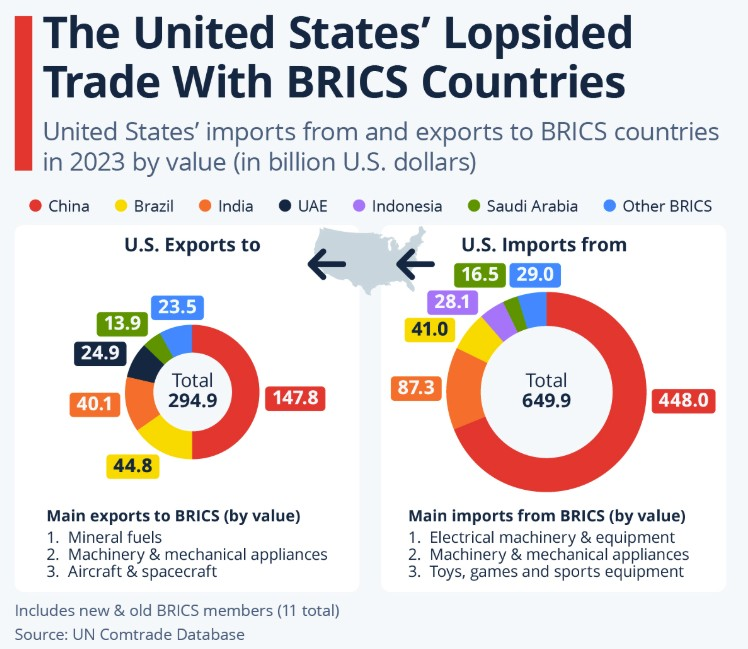

In [31]:
img = Image.open(ANALYZER_SAMPLE_FILE)
img

In [32]:
with open(ANALYZER_TEMPLATE_FILE, 'r') as f:
    print(f.read())

{
  "description": "Extract detailed structured information from charts and diagrams.",
  "scenario": "image",
  "config": {
      "returnDetails": false
  },
  "fieldSchema": {
      "name": "ChartAndDiagram",
      "description": "Structured information from charts and diagrams.",
      "fields": {
          "Title": {
              "type": "string",
              "method": "generate",
              "description": "Verbatim title of the chart."
          },
          "ChartType": {
              "type": "string",
              "method": "classify",
              "description": "The type of chart.",
              "enum": [
                  "area",
                  "bar",
                  "box",
                  "bubble",
                  "candlestick",
                  "funnel",
                  "heatmap",
                  "histogram",
                  "line",
                  "pie",
                  "radar",
                  "rings",
                  "rose",
            

In [33]:
# Create analyzer
response = client.begin_create_analyzer(
    ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_FILE)
result = client.poll_result(response)

# Analyzer file
response = client.begin_analyze(ANALYZER_ID,
                                file_location=ANALYZER_SAMPLE_FILE)
result = client.poll_result(response)

In [34]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "0bc29f58-cc3c-4565-9e7b-8f0290ea519c",
    "status": "Succeeded",
    "result": {
        "analyzerId": "content-doc-sample-28Jan2025145707",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-01-28T14:57:08Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "![image](image)\n",
                "fields": {
                    "Title": {
                        "type": "string",
                        "valueString": "The United States' Lopsided Trade With BRICS Countries"
                    },
                    "ChartType": {
                        "type": "string",
                        "valueString": "rings"
                    },
                    "TopicKeywords": {
                        "type": "array",
                        "valueArray": [
                            {
                                "type": "string",
                                "valueString": "BRICS"
                        

In [35]:
print("\033[1;31;34m")
print(json.dumps(result["result"]["contents"][0]["fields"], indent=4))


{
    "Title": {
        "type": "string",
        "valueString": "The United States' Lopsided Trade With BRICS Countries"
    },
    "ChartType": {
        "type": "string",
        "valueString": "rings"
    },
    "TopicKeywords": {
        "type": "array",
        "valueArray": [
            {
                "type": "string",
                "valueString": "BRICS"
            },
            {
                "type": "string",
                "valueString": "Economics"
            },
            {
                "type": "string",
                "valueString": "International trade"
            },
            {
                "type": "string",
                "valueString": "United States"
            }
        ]
    },
    "DetailedDescription": {
        "type": "string",
        "valueString": "The chart illustrates the United States' trade with BRICS countries in 2023, showing both exports and imports in billion U.S. dollars. The U.S. exports to BRICS countries total $294.9 b

In [36]:
client.delete_analyzer(ANALYZER_ID)

<Response [204]>

## Call center recording example

In [37]:
ANALYZER_SAMPLE_FILE = os.path.join(DOCS_DIR, 'callcenter.mp3')

ANALYZER_TEMPLATE_FILE = os.path.join(JSON_DIR,
                                      'call_recording_analytics.json')
ANALYZER_ID = f"content-doc-sample-{(datetime.datetime.today().strftime('%d%b%Y%H%M%S'))}"

In [38]:
Audio(ANALYZER_SAMPLE_FILE, autoplay=False)

In [39]:
with open(ANALYZER_TEMPLATE_FILE, 'r') as f:
    print(f.read())

{
  "description": "Sample call recording analytics",
  "scenario": "callCenter",
  "config": {
    "returnDetails": true,
    "locales": ["en-US"]
  },
  "fieldSchema": {
    "fields": {
      "Summary": {
        "type": "string",
        "method": "generate",
        "description": "A one-paragraph summary"
      },
      "Topics": {
        "type": "array",
        "method": "generate",
        "description": "Top 5 topics mentioned",
        "items": {
          "type": "string"
        }
      },
      "Companies": {
        "type": "array",
        "method": "generate",
        "description": "List of companies mentioned",
        "items": {
          "type": "string"
        }
      },
      "People": {
        "type": "array",
        "method": "generate",
        "description": "List of people mentioned",
        "items": {
          "type": "object",
          "properties": {
            "Name": {
              "type": "string",
              "description": "Person's name"
 

In [40]:
# Create analyzer
response = client.begin_create_analyzer(
    ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_FILE)
result = client.poll_result(response)

# Analyzer file
response = client.begin_analyze(ANALYZER_ID,
                                file_location=ANALYZER_SAMPLE_FILE)
result = client.poll_result(response)

In [41]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "2688fd0d-944f-458a-84dc-9fe0896e6079",
    "status": "Succeeded",
    "result": {
        "analyzerId": "content-doc-sample-28Jan2025145725",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-01-28T14:57:29Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "```WEBVTT\n\n00:00.080 --> 00:00.640\n<v Agent>Good day.\n\n00:00.960 --> 00:02.240\n<v Agent>Welcome to Contoso.\n\n00:02.560 --> 00:03.760\n<v Agent>My name is John Doe.\n\n00:03.920 --> 00:05.120\n<v Agent>How can I help you today?\n\n00:05.440 --> 00:06.320\n<v Customer>Yes, good day.\n\n00:06.640 --> 00:08.160\n<v Customer>My name is Maria Smith.\n\n00:08.560 --> 00:11.360\n<v Customer>I would like to inquire about my current point balance.\n\n00:11.680 --> 00:12.560\n<v Agent>No problem.\n\n00:12.880 --> 00:13.920\n<v Agent>I am happy to help.\n\n00:14.240 --> 00:16.800\n<v Agent>I need your date of birth to confirm your identity.\n\n00:17.120 --> 00:1

In [42]:
result

{'id': '2688fd0d-944f-458a-84dc-9fe0896e6079',
 'status': 'Succeeded',
 'result': {'analyzerId': 'content-doc-sample-28Jan2025145725',
  'apiVersion': '2024-12-01-preview',
  'createdAt': '2025-01-28T14:57:29Z',
  'warnings': [],
  'contents': [{'markdown': "```WEBVTT\n\n00:00.080 --> 00:00.640\n<v Agent>Good day.\n\n00:00.960 --> 00:02.240\n<v Agent>Welcome to Contoso.\n\n00:02.560 --> 00:03.760\n<v Agent>My name is John Doe.\n\n00:03.920 --> 00:05.120\n<v Agent>How can I help you today?\n\n00:05.440 --> 00:06.320\n<v Customer>Yes, good day.\n\n00:06.640 --> 00:08.160\n<v Customer>My name is Maria Smith.\n\n00:08.560 --> 00:11.360\n<v Customer>I would like to inquire about my current point balance.\n\n00:11.680 --> 00:12.560\n<v Agent>No problem.\n\n00:12.880 --> 00:13.920\n<v Agent>I am happy to help.\n\n00:14.240 --> 00:16.800\n<v Agent>I need your date of birth to confirm your identity.\n\n00:17.120 --> 00:19.600\n<v Customer>It is April 19th, 1988.\n\n00:20.000 --> 00:20.480\n<v A

In [43]:
print("\033[1;31;34m")
print(json.dumps(result["result"]["contents"][0]["fields"], indent=4))


{
    "Sentiment": {
        "type": "string",
        "valueString": "Neutral"
    },
    "Summary": {
        "type": "string",
        "valueString": "Maria Smith contacted Contoso to inquire about her current point balance. Agent John Doe confirmed her identity and informed her that she has 599 points. Maria did not require any further information and ended the call."
    },
    "Categories": {
        "type": "array"
    },
    "Companies": {
        "type": "array",
        "valueArray": [
            {
                "type": "string",
                "valueString": "Contoso"
            }
        ]
    },
    "People": {
        "type": "array",
        "valueArray": [
            {
                "type": "object",
                "valueObject": {
                    "Name": {
                        "type": "string",
                        "valueString": "John Doe"
                    },
                    "Role": {
                        "type": "string",
               

In [44]:
client.delete_analyzer(ANALYZER_ID)

<Response [204]>

## Video example

In [45]:
ANALYZER_SAMPLE_FILE = os.path.join(DOCS_DIR, 'video.mp4')

ANALYZER_TEMPLATE_FILE = os.path.join(JSON_DIR, 'marketing_video.json')
ANALYZER_ID = f"content-doc-sample-{(datetime.datetime.today().strftime('%d%b%Y%H%M%S'))}"

In [46]:
Video(ANALYZER_SAMPLE_FILE, width=512)

In [47]:
with open(ANALYZER_TEMPLATE_FILE, 'r') as f:
    print(f.read())

{
  "description": "Sample marketing video analyzer",
  "scenario": "videoShot",
  "config": {
    "returnDetails": true
  },
  "fieldSchema": {
    "fields": {
      "Description": {
        "type": "string",
        "description": "Detailed summary of the video segment, focusing on product characteristics, lighting, and color palette."
      },
      "Sentiment": {
        "type": "string",
        "method": "classify",
        "enum": [
          "Positive",
          "Neutral",
          "Negative"
        ]
      }
    }
  }
}


In [48]:
# Create analyzer
response = client.begin_create_analyzer(
    ANALYZER_ID, analyzer_template_path=ANALYZER_TEMPLATE_FILE)
result = client.poll_result(response)

# Analyzer file
response = client.begin_analyze(ANALYZER_ID,
                                file_location=ANALYZER_SAMPLE_FILE)
result = client.poll_result(response)

In [49]:
print("\033[1;31;34m")
print(json.dumps(result, indent=4))


{
    "id": "8b0d67ae-e55e-422c-8423-c604f5e6373b",
    "status": "Succeeded",
    "result": {
        "analyzerId": "content-doc-sample-28Jan2025145738",
        "apiVersion": "2024-12-01-preview",
        "createdAt": "2025-01-28T14:57:40Z",
        "warnings": [],
        "contents": [
            {
                "markdown": "# Shot 00:00.000 => 00:16.866\n## Transcript\n```\nWEBVTT\n\n00:00.240 --> 00:03.520\n<v Speaker>You've got a new version of Windows powered by A I.\n00:03.520 --> 00:07.840\n<v Speaker>That basically means you have your own A I agent on your own device.\n00:08.160 --> 00:13.280\n<v Speaker>How will this A I powered hardware experience be totally different from what we've seen before?\n00:13.680 --> 00:15.440\n<v Speaker>First of all, thank you so much for having me, Emily.\n00:15.440 --> 00:23.200\n<v Speaker>And yeah, I mean it's really a ground up, you know, re-imagination from silicon.\n```\n## Key Frames\n- 00:00.900 ![](keyFrame.900.jpg)\n- 00:01.800 !

In [50]:
print("\033[1;31;34m")
print(json.dumps(result["result"]["contents"][0]["fields"], indent=4))


{
    "sentiment": {
        "type": "string",
        "valueString": "Positive"
    },
    "description": {
        "type": "string",
        "valueString": "The segment features an interview setting with two individuals sitting across a modern coffee table in a stylishly furnished room. The background consists of large windows with sheer curtains, allowing natural light to gently illuminate the room, and lush green plants adding a touch of freshness. The d\u00e9cor includes deep-toned armchairs and a dark-colored couch, contributing to a professional yet relaxed ambiance. The interview revolves around the introduction of a new version of Windows that leverages AI technology, marking a significant shift in user experience from traditional hardware setups."
    }
}


In [51]:
client.delete_analyzer(ANALYZER_ID)

<Response [204]>